### Imagenette dataset loader


In [1]:
import os
import tarfile
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from fastdownload import FastDownload


def download_and_extract_imagenette(dest_root="data"):
    """
    自動下載並解壓 ImageNette-320 資料集
    """
    fd = FastDownload()
    archive_path = fd.download("https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz")
    extract_path = os.path.join(dest_root, "imagenette2-320")

    if not os.path.exists(extract_path):
        print(f"解壓縮到 {extract_path} ...")
        with tarfile.open(archive_path, "r:gz") as tar:
            tar.extractall(dest_root)
        print("解壓完成")
    else:
        print("已存在，不需解壓")

    return extract_path


def get_imagenette_loaders(batch_size, root="data", split_ratio=0.1):
    """
    回傳 train / val / test 的 PyTorch Dataloader
    """
    imagenette_root = download_and_extract_imagenette(root)

    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225),
        ),
    ])

    eval_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225),
        ),
    ])

    # train 和 val 共用 train 資料夾
    full_trainset = ImageFolder(root=os.path.join(imagenette_root, "train"), transform=transform)
    testset = ImageFolder(root=os.path.join(imagenette_root, "val"), transform=eval_transform)

    # 修正 random_split 精度誤差
    total_len = len(full_trainset)
    val_len = int(split_ratio * total_len)
    train_len = total_len - val_len
    trainset, valset = random_split(full_trainset, [train_len, val_len])

    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    valloader = DataLoader(valset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    return trainloader, valloader, testloader



DATALOADERS = {
    "imagenette": get_imagenette_loaders,
}

# 測試執行
if __name__ == "__main__":
    trainloader, valloader, testloader = DATALOADERS["imagenette"](batch_size=64)
    x, y = trainloader.dataset[0]
    print(f"imagenette 資料集載入成功")
    print(f"train = {len(trainloader.dataset)}, val = {len(valloader.dataset)}, test = {len(testloader.dataset)}, shape = {x.shape}")


解壓縮到 data/imagenette2-320 ...
解壓完成
imagenette 資料集載入成功
train = 8523, val = 946, test = 3925, shape = torch.Size([3, 224, 224])


#### Useful utilities
- ``evaluate(model, loader, criterion, device)`` – Evaluates a model on a dataset, computing loss, accuracy, and confusion matrix.
- ``plot_loss_accuracy(train_loss, train_acc, val_loss, val_acc, filename)`` – Plots and saves the training and validation loss/accuracy curves.
- ``save_model(model, filename, verbose, existed)`` – Saves a PyTorch model's state dictionary while handling filename conflicts.
- ``load_model(model, filename, qconfig, fuse_modules, verbose)`` – Loads a saved model, optionally applying quantization and module fusion.
- ``reset_seed(seed)`` – Sets seeds for PyTorch and NumPy to ensure reproducibility.
- ``plot_confusion_matrix(conf_matrix, filename)`` – Generates and saves a heatmap of the confusion matrix for CIFAR-10 classification.



In [ ]:
import os

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import torch
import torch.ao.quantization as tq
from tqdm.notebook import tqdm

DEFAULT_DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


def evaluate(model, loader, criterion, device=DEFAULT_DEVICE):
    running_loss = 0
    total, correct = 0, 0
    all_preds, all_labels = [], []

    model.eval()
    with torch.no_grad():
        loop = tqdm(loader, desc="Evaluating", leave=True)

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)

            running_loss += loss.item()
            predicted = torch.argmax(output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        loop.set_postfix(
            loss=running_loss / (total / images.shape[0]), accuracy=correct / total
        )

    avg_loss = running_loss / len(loader)
    accuracy = correct / total
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    return avg_loss, accuracy, conf_matrix


def preprocess_filename(filename: str, existed: str = "keep_both") -> str:
    if existed == "overwrite":
        pass
    elif existed == "keep_both":
        base, ext = os.path.splitext(filename)
        cnt = 1
        while os.path.exists(filename):
            filename = f"{base}-{cnt}{ext}"
            cnt += 1
    elif existed == "raise" and os.path.exists(filename):
        raise FileExistsError(f"{filename} already exists.")
    else:
        raise ValueError(f"Unknown value for 'existed': {existed}")
    return filename


def plot_loss_accuracy(
    train_loss, train_acc, val_loss, val_acc, filename="loss_accuracy.png"
):

    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.plot(train_loss, color="tab:blue")
    ax1.plot(val_loss, color="tab:red")
    ax1.legend(["Training", "Validation"])
    ax1.set_title("Loss")

    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.plot(train_acc, color="tab:blue")
    ax2.plot(val_acc, color="tab:red")
    ax2.legend(["Training", "Validation"])
    ax2.set_title("Accuracy")

    fig.tight_layout()
    filename = preprocess_filename(filename)
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    plt.savefig(filename)
    print(f"Plot saved at {filename}")


def plot_confusion_matrix(conf_matrix, filename="conf_matrix.png"):
    classes = [
    "tench",
    "English springer",
    "cassette player",
    "chain saw",
    "church",
    "French horn",
    "garbage truck",
    "gas pump",
    "golf ball",
    "parachute",
    ]

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=classes,
        yticklabels=classes,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix for ImageNette Classification")
    plt.tight_layout()

    filename = preprocess_filename(filename)
    plt.savefig(filename)
    print(f"Confusion matrix saved to {filename}")


def save_model(
    model, filename: str, verbose: bool = True, existed: str = "keep_both"
) -> None:
    filename = preprocess_filename(filename, existed)

    os.makedirs(os.path.dirname(filename), exist_ok=True)
    torch.save(model.state_dict(), filename)
    if verbose:
        print(f"Model saved at {filename} ({os.path.getsize(filename) / 1e6} MB)")
    else:
        print(f"Model saved at {filename}")


def load_model(
    model, filename: str, qconfig=None, fuse_modules: bool = False, verbose: bool = True
) -> torch.nn.Module:
    if fuse_modules and hasattr(model, "fuse_modules"):
        print("Fusing modules")
        model.fuse_modules()
    else:
        print("Model does not have 'fuse_modules' method. Skipping fusion.")

    if qconfig is not None:
        model = tq.QuantWrapper(model)
        model.qconfig = qconfig
        tq.prepare(model, inplace=True)
        tq.convert(model, inplace=True)

    device = DEFAULT_DEVICE if qconfig is None else "cpu"
    model.load_state_dict(torch.load(filename, map_location=device))

    if verbose:
        print(f"Model loaded from {filename} ({os.path.getsize(filename) / 1e6} MB)")
    return model


def reset_seed(seed: int = 42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False



### MobileNetV2

#### Implement your model based on the given model architecture in the lab material.



In [ ]:
import torch
import torch.nn as nn
import torch.quantization as tq
import torch.nn.functional as F



#---------------------------------------------------------------------------#
# 1) Inverted Residual Block
#---------------------------------------------------------------------------#
class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super().__init__()
        self.stride = stride
        hidden_dim = int(inp * expand_ratio)
        self.use_res_connect = (self.stride == 1 and inp == oup)

        layers = []
        # 1x1 expand
        if expand_ratio != 1:
            layers += [
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU(inplace=True)
            ]
        # 3x3 depthwise
        layers += [
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True),
        ]
        # 1x1 project
        layers += [
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup),
        ]
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

#---------------------------------------------------------------------------#
# 2) MobileNetV2
#---------------------------------------------------------------------------#
class MobileNetV2(nn.Module):
    def __init__(self, num_classes=10, width_mult=1.0):
        super().__init__()
        # [t, c, n, s]
        inverted_residual_setting = [
            # t,   c,   n,  s
            [1,    16,  1,  1],
            [6,    24,  2,  2],
            [6,    32,  3,  2],
            [6,    64,  4,  2],
            [6,    96,  3,  1],
            [6,   160,  3,  2],
            [6,   320,  1,  1],
        ]

        # 第一層 conv2d 3x3，輸出 32 channel
        input_channel = int(32 * width_mult)
        layers = [
            nn.Conv2d(3, input_channel, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(input_channel),
            nn.ReLU(inplace=True)
        ]

        # Inverted Residual Block
        for t, c, n, s in inverted_residual_setting:
            output_channel = int(c * width_mult)
            for i in range(n):
                stride = s if i == 0 else 1
                layers.append(InvertedResidual(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel

        # 收尾：1x1 conv to 1280 -> avgpool -> fc
        last_channel = int(1280 * width_mult) if width_mult > 1.0 else 1280
        layers += [
            nn.Conv2d(input_channel, last_channel, 1, 1, 0, bias=False),
            nn.BatchNorm2d(last_channel),
            nn.ReLU(inplace=True),
        ]
        self.features = nn.Sequential(*layers)

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(

            nn.Linear(last_channel, num_classes)
        )

        # 權重初始化
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x).view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def fuse_modules(self):
        # 1) fuse 首層 conv-bn-relu
        tq.fuse_modules(self.features, ['0', '1', '2'], inplace=True)

        # 2) fuse 所有 InvertedResidual
        for m in self.features:
            if isinstance(m, InvertedResidual):
                # layers 順序：
                # 如果 expand_ratio != 1: [0:Conv,1:BN,2:ReLU]；
                # 然后 [3:Conv_dw,4:BN,5:ReLU]；
                # 最后 [6:Conv_pw,7:BN]
                if len(m.conv) == 8:
                    tq.fuse_modules(m.conv, ['0','1','2'], inplace=True)
                    tq.fuse_modules(m.conv, ['3','4','5'], inplace=True)
                    tq.fuse_modules(m.conv, ['6','7'], inplace=True)
                else:
                    # expand_ratio==1 時，直接從 depthwise 開始
                    tq.fuse_modules(m.conv, ['0','1','2'], inplace=True)
                    tq.fuse_modules(m.conv, ['3','4'], inplace=True)

        # 3) fuse 最后一個 1×1 conv-bn-relu
        # features 中最后三個層的索引是 -3,-2,-1
        N = len(self.features)
        tq.fuse_modules(self.features, [str(N-3), str(N-2), str(N-1)], inplace=True)









if __name__ == "__main__":
    model = MobileNetV2()
    inputs = torch.randn(1, 3, 224, 224)
    print(model)

    from torchsummary import summary

    summary(model, (3, 224, 224), device="cpu")


MobileNetV2(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (4): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(96, 96, kernel_size=(3,

### QConfig
#### Quantization scheme
- Write your QConfig Observer inorder to do PTQ
- Use Power-of-Two uniform/scale, symmetric quantization to quantize model.
- Finish qconfig observer for PTQ calibration.


In [ ]:
from enum import Enum
import math

import torch
import torch.ao.quantization as tq


class PowerOfTwoObserver(tq.MinMaxObserver):
    """
    Observer module for power-of-two quantization (dyadic quantization with b = 1).
    """

    def scale_approximate(self, scale: float, max_shift_amount=8) -> float:
        #########Implement your code here##########
        # Handle edge cases
        if not math.isfinite(scale) or scale <= 0:
            return 1.0

        try:
            log2_scale = math.log2(scale)

            # Constrain log2_scale to prevent overflow
            log2_scale = max(min(log2_scale, max_shift_amount), -max_shift_amount)

            # Round to nearest power of two within constraints
            candidate = round(log2_scale)

            # Convert back to scale
            approx_scale = 2 ** candidate

            return approx_scale

        except (OverflowError, ValueError):
            # Fallback mechanism
            return 1.0
        ##########################################

    def calculate_qparams(self):
        """Calculates the quantization parameters with scale as power of two."""
        min_val, max_val = self.min_val.item(), self.max_val.item()

        """ Calculate zero_point as in the base class """
        # Find the absolute maximum to determine the range symmetrically
        abs_max = max(abs(min_val), abs(max_val))

        # Calculate the initial scale based on the full range
        scale = abs_max / (2 ** (self.dtype.itemsize * 8 - 1) - 1)

        # Determine zero point based on dtype
        #  0~255 : 128
        # -128~127 : 0
        if self.dtype == torch.qint8:
            zero_point = 0
        elif self.dtype == torch.quint8:
            zero_point = 128
        else:
            zero_point = 0  # Default fallback

        scale = self.scale_approximate(scale)
        scale = torch.tensor(scale, dtype=torch.float32)
        zero_point = torch.tensor(zero_point, dtype=torch.int64)
        return scale, zero_point

    def extra_repr(self):
        return f"min_val={self.min_val}, max_val={self.max_val}, scale=PowerOfTwo"


class CustomQConfig(Enum):
    POWER2 = tq.QConfig(
        activation=PowerOfTwoObserver.with_args(
            dtype=torch.quint8, qscheme=torch.per_tensor_symmetric
        ),
        weight=PowerOfTwoObserver.with_args(
            dtype=torch.qint8, qscheme=torch.per_tensor_symmetric
        ),
    )
    DEFAULT = None

### Model Training

- Set hyper parameter for training.
- Record the number of epochs and the accuracy in the results.
- Plot the accuracy and loss.



已存在，不需解壓


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch  1/50  lr=1.00e-03, train_loss=1.7535, val_loss=1.8538, train_acc=0.3867, val_acc=0.4450
Model saved at weights/imagenette/mobilenetv2.pt (9.190198 MB)


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch  2/50  lr=1.00e-03, train_loss=1.3545, val_loss=1.4108, train_acc=0.5499, val_acc=0.5634
Model saved at weights/imagenette/mobilenetv2.pt (9.190198 MB)


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch  3/50  lr=1.00e-03, train_loss=1.1674, val_loss=1.2709, train_acc=0.6161, val_acc=0.6089
Model saved at weights/imagenette/mobilenetv2.pt (9.190198 MB)


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch  4/50  lr=1.00e-03, train_loss=1.0512, val_loss=1.1813, train_acc=0.6593, val_acc=0.6342
Model saved at weights/imagenette/mobilenetv2.pt (9.190198 MB)


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch  5/50  lr=1.00e-03, train_loss=0.9480, val_loss=1.1221, train_acc=0.6900, val_acc=0.6480
Model saved at weights/imagenette/mobilenetv2.pt (9.190198 MB)


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch  6/50  lr=1.00e-03, train_loss=0.8893, val_loss=1.2784, train_acc=0.7102, val_acc=0.6247


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch  7/50  lr=1.00e-03, train_loss=0.8178, val_loss=1.0692, train_acc=0.7346, val_acc=0.6480
Model saved at weights/imagenette/mobilenetv2.pt (9.190198 MB)


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch  8/50  lr=1.00e-03, train_loss=0.7652, val_loss=0.9652, train_acc=0.7576, val_acc=0.6882
Model saved at weights/imagenette/mobilenetv2.pt (9.190198 MB)


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch  9/50  lr=1.00e-03, train_loss=0.7243, val_loss=0.8252, train_acc=0.7669, val_acc=0.7495
Model saved at weights/imagenette/mobilenetv2.pt (9.190198 MB)


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 10/50  lr=1.00e-03, train_loss=0.7000, val_loss=0.8302, train_acc=0.7760, val_acc=0.7315


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 11/50  lr=1.00e-03, train_loss=0.6695, val_loss=0.8364, train_acc=0.7865, val_acc=0.7262


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 12/50  lr=1.00e-03, train_loss=0.6392, val_loss=0.7824, train_acc=0.7981, val_acc=0.7558
Model saved at weights/imagenette/mobilenetv2.pt (9.190198 MB)


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 13/50  lr=1.00e-03, train_loss=0.5994, val_loss=0.7768, train_acc=0.8082, val_acc=0.7611
Model saved at weights/imagenette/mobilenetv2.pt (9.190198 MB)


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 14/50  lr=1.00e-03, train_loss=0.5750, val_loss=0.7943, train_acc=0.8208, val_acc=0.7590


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 15/50  lr=1.00e-03, train_loss=0.5613, val_loss=1.0477, train_acc=0.8221, val_acc=0.6913


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 16/50  lr=1.00e-03, train_loss=0.5302, val_loss=0.7504, train_acc=0.8278, val_acc=0.7622
Model saved at weights/imagenette/mobilenetv2.pt (9.190198 MB)


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 17/50  lr=1.00e-03, train_loss=0.5007, val_loss=0.7122, train_acc=0.8386, val_acc=0.7717
Model saved at weights/imagenette/mobilenetv2.pt (9.190198 MB)


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 18/50  lr=1.00e-03, train_loss=0.4886, val_loss=0.6610, train_acc=0.8415, val_acc=0.7949
Model saved at weights/imagenette/mobilenetv2.pt (9.190198 MB)


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 19/50  lr=1.00e-03, train_loss=0.4891, val_loss=0.6213, train_acc=0.8397, val_acc=0.8013
Model saved at weights/imagenette/mobilenetv2.pt (9.190198 MB)


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 20/50  lr=1.00e-03, train_loss=0.4517, val_loss=0.6677, train_acc=0.8531, val_acc=0.8013
Model saved at weights/imagenette/mobilenetv2.pt (9.190198 MB)


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 21/50  lr=1.00e-03, train_loss=0.4266, val_loss=0.6792, train_acc=0.8631, val_acc=0.7854


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 22/50  lr=1.00e-03, train_loss=0.4418, val_loss=0.6890, train_acc=0.8579, val_acc=0.7886


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 23/50  lr=2.00e-04, train_loss=0.3197, val_loss=0.4772, train_acc=0.8964, val_acc=0.8457
Model saved at weights/imagenette/mobilenetv2.pt (9.190198 MB)


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 24/50  lr=2.00e-04, train_loss=0.2675, val_loss=0.4653, train_acc=0.9107, val_acc=0.8510
Model saved at weights/imagenette/mobilenetv2.pt (9.190198 MB)


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 25/50  lr=2.00e-04, train_loss=0.2591, val_loss=0.4894, train_acc=0.9147, val_acc=0.8393


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 26/50  lr=2.00e-04, train_loss=0.2456, val_loss=0.4735, train_acc=0.9193, val_acc=0.8436


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 27/50  lr=2.00e-04, train_loss=0.2353, val_loss=0.4516, train_acc=0.9237, val_acc=0.8467


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 28/50  lr=2.00e-04, train_loss=0.2238, val_loss=0.4887, train_acc=0.9263, val_acc=0.8499


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 29/50  lr=2.00e-04, train_loss=0.2257, val_loss=0.4969, train_acc=0.9256, val_acc=0.8552
Model saved at weights/imagenette/mobilenetv2.pt (9.190198 MB)


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 30/50  lr=2.00e-04, train_loss=0.2122, val_loss=0.4760, train_acc=0.9316, val_acc=0.8605
Model saved at weights/imagenette/mobilenetv2.pt (9.190198 MB)


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 31/50  lr=4.00e-05, train_loss=0.1844, val_loss=0.4927, train_acc=0.9413, val_acc=0.8499


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 32/50  lr=4.00e-05, train_loss=0.1794, val_loss=0.4900, train_acc=0.9454, val_acc=0.8488


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 33/50  lr=4.00e-05, train_loss=0.1759, val_loss=0.4746, train_acc=0.9483, val_acc=0.8615
Model saved at weights/imagenette/mobilenetv2.pt (9.190198 MB)


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 34/50  lr=8.00e-06, train_loss=0.1694, val_loss=0.4808, train_acc=0.9488, val_acc=0.8615
Model saved at weights/imagenette/mobilenetv2.pt (9.190198 MB)


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 35/50  lr=8.00e-06, train_loss=0.1590, val_loss=0.4472, train_acc=0.9498, val_acc=0.8710
Model saved at weights/imagenette/mobilenetv2.pt (9.190198 MB)


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 36/50  lr=8.00e-06, train_loss=0.1687, val_loss=0.4739, train_acc=0.9449, val_acc=0.8499


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 37/50  lr=8.00e-06, train_loss=0.1577, val_loss=0.4930, train_acc=0.9513, val_acc=0.8615


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 38/50  lr=8.00e-06, train_loss=0.1550, val_loss=0.4628, train_acc=0.9517, val_acc=0.8636


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 39/50  lr=1.60e-06, train_loss=0.1595, val_loss=0.4650, train_acc=0.9510, val_acc=0.8658


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 40/50  lr=1.60e-06, train_loss=0.1583, val_loss=0.4681, train_acc=0.9491, val_acc=0.8636


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 41/50  lr=1.60e-06, train_loss=0.1657, val_loss=0.4743, train_acc=0.9478, val_acc=0.8573


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 42/50  lr=3.20e-07, train_loss=0.1492, val_loss=0.4397, train_acc=0.9552, val_acc=0.8710
Model saved at weights/imagenette/mobilenetv2.pt (9.190198 MB)


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 43/50  lr=3.20e-07, train_loss=0.1614, val_loss=0.4776, train_acc=0.9487, val_acc=0.8626


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 44/50  lr=3.20e-07, train_loss=0.1609, val_loss=0.4508, train_acc=0.9487, val_acc=0.8700


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 45/50  lr=3.20e-07, train_loss=0.1605, val_loss=0.4631, train_acc=0.9520, val_acc=0.8636


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 46/50  lr=6.40e-08, train_loss=0.1593, val_loss=0.4775, train_acc=0.9519, val_acc=0.8647


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 47/50  lr=6.40e-08, train_loss=0.1727, val_loss=0.4681, train_acc=0.9480, val_acc=0.8636


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 48/50  lr=6.40e-08, train_loss=0.1605, val_loss=0.4579, train_acc=0.9495, val_acc=0.8488


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 49/50  lr=1.28e-08, train_loss=0.1634, val_loss=0.4699, train_acc=0.9478, val_acc=0.8605


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 50/50  lr=1.28e-08, train_loss=0.1518, val_loss=0.4699, train_acc=0.9518, val_acc=0.8573


Evaluating:   0%|          | 0/62 [00:00<?, ?it/s]

Test: loss=0.4423, accuracy=0.8703
Model size: 9.19 MB
Plot saved at figure/mobilenetv2-1.png
Time: 3535.31s


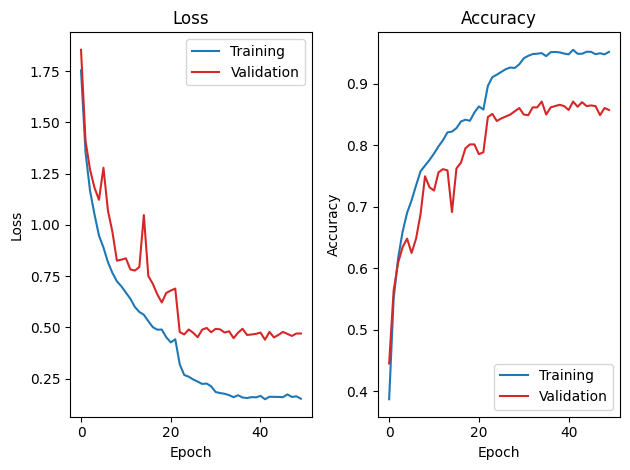

In [ ]:
import os
import time
import torch
from torch import nn, optim
from tqdm.notebook import tqdm

DEFAULT_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
reset_seed(20)

def train_one_epoch(model, loader, criterion, optimizer, device=DEFAULT_DEVICE):
    running_loss = 0
    total, correct = 0, 0

    loop = tqdm(loader, desc="Training", leave=True)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = torch.argmax(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix(
            loss=running_loss / (total / images.shape[0]), accuracy=correct / total
        )

    avg_loss = running_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy

def train(
    model,
    trainloader,
    valloader,
    criterion,
    optimizer,
    scheduler=None,
    epochs=1,
    save_path=None,
    device=DEFAULT_DEVICE,
):
    model = model.to(device)

    train_loss, train_acc = [], []
    val_loss, val_acc = [], []

    epoch_loop = tqdm(range(epochs), desc="Epochs", leave=True)
    for epoch in epoch_loop:
        model.train()
        _train_loss, _train_acc = train_one_epoch(model, trainloader, criterion, optimizer, device)
        train_loss.append(_train_loss)
        train_acc.append(_train_acc)

        model.eval()
        _val_loss, _val_acc, _ = evaluate(model, valloader, criterion)
        val_loss.append(_val_loss)
        val_acc.append(_val_acc)

        print(f"Epoch {epoch + 1:2d}/{epochs}", end="  ")
        if scheduler is not None:
            print(f"lr={optimizer.param_groups[0]['lr']:.2e}", end=", ")

        print(f"train_loss={_train_loss:.4f}, val_loss={_val_loss:.4f}", end=", ")
        print(f"train_acc={_train_acc:.4f}, val_acc={_val_acc:.4f}")

        if _val_acc >= max(val_acc):
            save_model(model, save_path, existed="overwrite")

        if scheduler is not None:
            scheduler.step(_val_loss)

        epoch_loop.set_postfix(
            train_loss=_train_loss,
            val_loss=_val_loss,
            train_acc=_train_acc,
            val_acc=_val_acc,
        )

    return train_loss, train_acc, val_loss, val_acc

def main(epochs, network, dataset, name=None):
    dataset = dataset.lower()
    if name is None:
        name = "mobilenetv2"

    t = time.time()
    trainloader, valloader, testloader = DATALOADERS[dataset](batch_size=64)
    in_channels, in_size = trainloader.dataset[0][0].shape[:2]
    model = network(num_classes=10).to(DEFAULT_DEVICE)  # 對 mobilenet 輸入 num_classes

    # 定義 loss 函數
    criterion = nn.CrossEntropyLoss()

    # 對 depthwise convolution 層加 L2 regularization，其餘不加
    depthwise_params = []
    other_params = []

    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d) and module.groups == module.in_channels and module.in_channels == module.out_channels:
            depthwise_params.append(module.weight)
            if module.bias is not None:
                other_params.append(module.bias)
        else:
            for param in module.parameters(recurse=False):
                other_params.append(param)

    optimizer = optim.Adam([
        {"params": depthwise_params, "weight_decay": 1e-4},
        {"params": other_params, "weight_decay": 0.0}
    ], lr=0.001)


    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2)

    save_path = "weights/imagenette/mobilenetv2.pt"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    train_loss, train_acc, val_loss, val_acc = train(
        model,
        trainloader,
        valloader,
        criterion,
        optimizer,
        scheduler,
        epochs,
        save_path=save_path,
    )

    test_loss, test_accuracy, _ = evaluate(model.eval(), testloader, criterion)
    print(f"Test: loss={test_loss:.4f}, accuracy={test_accuracy:.4f}")
    size_mb = os.path.getsize(save_path) / 1e6
    print(f"Model size: {size_mb:.2f} MB")

    fig_path = "figure/mobilenetv2.png"
    os.makedirs("figure", exist_ok=True)
    plot_loss_accuracy(train_loss, train_acc, val_loss, val_acc, fig_path)
    print(f"Time: {time.time() - t:.2f}s")

if __name__ == "__main__":
    for network in [MobileNetV2]:
        EPOCHS = 50
        main(epochs=EPOCHS, network=network, dataset="imagenette")


### PTQ on MobileNetV2 Model

#### You can refer to 'Quantization in Practice' in the lab material.



In [ ]:
import torch
import torch.ao.quantization as tq
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx


def calibrate(model, loader, device="cpu"):
    model.to(device)
    model.eval()
    print("Calibrating model with a few samples...")

    with torch.no_grad():
        for i, (images, _) in enumerate(loader):
            images = images.to(device)
            model(images)
            if i == 20:
                break

    print("Calibration completed!")


def main(network, verbose=False):
    dataset = "imagenette"
    train_loader, val_loader, test_loader = DATALOADERS[dataset](batch_size=1)

    model_fp32 = network().eval().cpu()
    model_fp32.load_state_dict(torch.load("weights/imagenette/mobilenetv2.pt", map_location="cpu"))
    print("\nLoaded FP32 model===============================================================================")
    print(model_fp32)

    # 使用 FX Graph Mode 進行量化（支援殘差）
    # qconfig = torch.ao.quantization.get_default_qconfig("fbgemm")
    qconfig = CustomQConfig.POWER2.value  # 選擇 Power-of-Two 量化方案

    qconfig_dict = {"": qconfig}
    example_inputs = (torch.randn(1, 3, 224, 224),)  # imagenette 輸入格式

    model_prepared = prepare_fx(model_fp32, qconfig_dict, example_inputs=example_inputs)

    # print("\nAfter prepare_fx:")
    # print(model_prepared)

    calibrate(model_prepared, test_loader)

    model_quantized = convert_fx(model_prepared)
    print("\nAfter convert_fx=================================================================================")
    print(model_quantized)

    quantized_model_path = "weights/imagenette/mobilenetv2-power2.pt"
    save_model(model_quantized, quantized_model_path, verbose=False, existed="overwrite")
    print(f"✅ Quantized model saved to {quantized_model_path}")


if __name__ == "__main__":
    main(network=MobileNetV2, verbose=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

已存在，不需解壓

Loaded FP32 model===============================================================================
MobileNetV2(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (4): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=

/usr/local/lib/python3.11/dist-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping instead.
  prepared = prepare(


Calibrating model with a few samples...
Calibration completed!

After convert_fx=================================================================================
GraphModule(
  (features): Module(
    (0): QuantizedConvReLU2d(3, 32, kernel_size=(3, 3), stride=(2, 2), scale=0.03125, zero_point=128, padding=(1, 1))
    (3): Module(
      (conv): Module(
        (0): QuantizedConvReLU2d(32, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.125, zero_point=128, padding=(1, 1), groups=32)
        (3): QuantizedConv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), scale=0.0625, zero_point=128)
      )
    )
    (4): Module(
      (conv): Module(
        (0): QuantizedConvReLU2d(16, 96, kernel_size=(1, 1), stride=(1, 1), scale=0.125, zero_point=128)
        (3): QuantizedConvReLU2d(96, 96, kernel_size=(3, 3), stride=(2, 2), scale=0.125, zero_point=128, padding=(1, 1), groups=96)
        (6): QuantizedConv2d(96, 24, kernel_size=(1, 1), stride=(1, 1), scale=0.0625, zero_point=128)
      )
    )
    (5

### Evaluate Quantized Model


In [ ]:
import torch

def bit_width_of_dtype(dtype):
    # 浮點用 finfo，整數用 iinfo；如果 dtype 不是 torch.dtype，就返回 None
    try:
        if dtype.is_floating_point:
            return torch.finfo(dtype).bits
        else:
            return torch.iinfo(dtype).bits
    except:
        return None


model_32_path = './weights/imagenette/mobilenetv2.pt'
model_8_path = './weights/imagenette/mobilenetv2-power2.pt'
state_fp32 = torch.load(model_32_path, map_location="cpu")
state_int8 = torch.load(model_8_path, map_location="cpu")

for tag, state in [("FP32 模型", state_fp32), ("INT8 模型", state_int8)]:
    print(f"\n=== {tag} 参数列表 ===")
    for name, val in state.items():

        if isinstance(val, torch.Tensor):
            dtype_obj = val.dtype
        elif isinstance(val, float):
            dtype_obj = torch.float32
        elif isinstance(val, int):
            dtype_obj = torch.int64   # Python int 通常是 64-bit
        else:

            dtype_obj = None

        # 2) 格式化 dtype 和計算 bit-width
        if dtype_obj is not None:
            dtype_str = str(dtype_obj)
            bw = bit_width_of_dtype(dtype_obj)
        else:

            dtype_str = repr(val)
            bw = ""


        print(f"{name:<50} dtype={dtype_str:<12} bit-width={bw}")



=== FP32 模型 参数列表 ===
features.0.weight                                  dtype=torch.float32 bit-width=32
features.1.weight                                  dtype=torch.float32 bit-width=32
features.1.bias                                    dtype=torch.float32 bit-width=32
features.1.running_mean                            dtype=torch.float32 bit-width=32
features.1.running_var                             dtype=torch.float32 bit-width=32
features.1.num_batches_tracked                     dtype=torch.int64  bit-width=64
features.3.conv.0.weight                           dtype=torch.float32 bit-width=32
features.3.conv.1.weight                           dtype=torch.float32 bit-width=32
features.3.conv.1.bias                             dtype=torch.float32 bit-width=32
features.3.conv.1.running_mean                     dtype=torch.float32 bit-width=32
features.3.conv.1.running_var                      dtype=torch.float32 bit-width=32
features.3.conv.1.num_batches_tracked              dtyp

/usr/local/lib/python3.11/dist-packages/torch/_utils.py:410: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,


In [ ]:
import torch

sd = torch.load("weights/imagenette/mobilenetv2-power2.pt", map_location="cpu")
print("→ state_dict is a", type(sd))
print("→ bias-related keys in state_dict:")
for k in sd.keys():
    if "weight" in k:
        print("   ", k)


→ state_dict is a <class 'collections.OrderedDict'>
→ bias-related keys in state_dict:
    features.0.weight
    features.3.conv.0.weight
    features.3.conv.3.weight
    features.4.conv.0.weight
    features.4.conv.3.weight
    features.4.conv.6.weight
    features.5.conv.0.weight
    features.5.conv.3.weight
    features.5.conv.6.weight
    features.6.conv.0.weight
    features.6.conv.3.weight
    features.6.conv.6.weight
    features.7.conv.0.weight
    features.7.conv.3.weight
    features.7.conv.6.weight
    features.8.conv.0.weight
    features.8.conv.3.weight
    features.8.conv.6.weight
    features.9.conv.0.weight
    features.9.conv.3.weight
    features.9.conv.6.weight
    features.10.conv.0.weight
    features.10.conv.3.weight
    features.10.conv.6.weight
    features.11.conv.0.weight
    features.11.conv.3.weight
    features.11.conv.6.weight
    features.12.conv.0.weight
    features.12.conv.3.weight
    features.12.conv.6.weight
    features.13.conv.0.weight
    feature

In [ ]:
import torch

# 1. 載入儲存的 state_dict
sd = torch.load("weights/imagenette/mobilenetv2-power2.pt", map_location="cpu")

for key, tensor in sd.items():
    # 2. 如果它是 quantized Tensor，就能直接 q_scale()/q_zero_point()
    if isinstance(tensor, torch.Tensor) and tensor.is_quantized:
        print(f"{key:40s} • qscale={tensor.q_scale():.6f}  qzp={tensor.q_zero_point()}")
    # 3. 有些 activation 的 scale/zero_point 會以普通 Tensor 存成 key+".scale" / key+".zero_point"
    elif key.endswith(".scale") or key.endswith("zero_point"):
        print(f"{key:40s} = {tensor}")



features.0.weight                        • qscale=0.007812  qzp=0
features.0.scale                         = 0.03125
features.0.zero_point                    = 128
features.3.conv.0.weight                 • qscale=0.031250  qzp=0
features.3.conv.0.scale                  = 0.125
features.3.conv.0.zero_point             = 128
features.3.conv.3.weight                 • qscale=0.007812  qzp=0
features.3.conv.3.scale                  = 0.0625
features.3.conv.3.zero_point             = 128
features.4.conv.0.weight                 • qscale=0.007812  qzp=0
features.4.conv.0.scale                  = 0.125
features.4.conv.0.zero_point             = 128
features.4.conv.3.weight                 • qscale=0.015625  qzp=0
features.4.conv.3.scale                  = 0.125
features.4.conv.3.zero_point             = 128
features.4.conv.6.weight                 • qscale=0.003906  qzp=0
features.4.conv.6.scale                  = 0.0625
features.4.conv.6.zero_point             = 128
features.5.conv.0.weight

In [ ]:
def load_fx_model(
    model_class,
    model_path: str,
    example_input,
    qconfig=None,
    fuse_modules: bool = False,
    verbose: bool = True
) -> torch.nn.Module:
    model = model_class()
    model.eval()

    # 模組融合（如果有 fuse_modules 方法）
    if fuse_modules and hasattr(model, "fuse_modules"):
        print("Fusing modules")
        model.fuse_modules()
    elif fuse_modules:
        print("Model does not have 'fuse_modules' method. Skipping fusion.")

    if qconfig is not None:
        # FX Graph Mode 量化
        qconfig_dict = {"": qconfig}
        model_prepared = prepare_fx(model, qconfig_dict, example_inputs=(example_input,))
        model_quantized = convert_fx(model_prepared)
        model_quantized.load_state_dict(torch.load(model_path, map_location="cpu"))
        model = model_quantized
        device = "cpu"
    else:
        # 非量化：直接載入模型參數
        model.load_state_dict(torch.load(model_path, map_location=DEFAULT_DEVICE))
        device = DEFAULT_DEVICE

    if verbose:
        print(f"Model loaded from {model_path} ({os.path.getsize(model_path) / 1e6:.2f} MB)")

    return model.to(device)

In [ ]:
import os
from torch import nn
import torch.ao.quantization as tq

reset_seed(0)

def main():
    dataset = 'imagenette'
    backend = 'power2'
    model_path = './weights/imagenette/mobilenetv2-power2.pt'

    *_, test_loader = DATALOADERS[dataset](batch_size=1000)
    in_channels, in_size = test_loader.dataset[0][0].shape[:2]
    if backend:
        qconfig = CustomQConfig[backend.upper()].value
        fuse_modules = True
        print("Need Fuse Modules")
    else:
        qconfig = None
        fuse_modules = False

    example_input = torch.randn(1, 3, 224, 224)
    model = load_fx_model(MobileNetV2, model_path, example_input, qconfig, fuse_modules=fuse_modules)

    # print(model)

    device = "cpu" if backend else DEFAULT_DEVICE
    criterion = nn.CrossEntropyLoss()
    test_loss, test_accuracy, _ = evaluate(
        model.to(device), test_loader, criterion, device=device
    )
    print(
        f"Test: loss={test_loss:.4f}, accuracy={test_accuracy:.4f}, size={os.path.getsize(model_path) / 1e6}MB"
    )


if __name__ == "__main__":
    main()



已存在，不需解壓
Need Fuse Modules
Fusing modules
Model loaded from ./weights/imagenette/mobilenetv2-power2.pt (2.35 MB)


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Test: loss=0.4556, accuracy=0.8688, size=2.3478MB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
